/var/folders/b0/3m9ppxz93zl2xj3hppxlrzbw0000gn/T/ipykernel_27828/1760083977.py:33: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [b]


/opt/anaconda3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/anaconda3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/anaconda3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/anaconda3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 46 seconds.
/opt/anaconda3/envs/bayes/lib/python3.10/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not u

       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
b[0] -0.080  0.097  -0.263    0.099      0.001    0.001   26391.0   14572.0   
b[1]  0.423  0.098   0.239    0.607      0.001    0.000   24559.0   15056.0   
b[2] -0.489  0.097  -0.668   -0.306      0.001    0.000   25805.0   15668.0   

      r_hat  
b[0]    1.0  
b[1]    1.0  
b[2]    1.0  


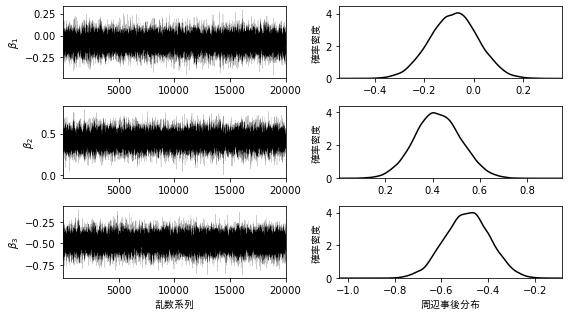

In [1]:
import numpy as np
import scipy.stats as st
import scipy.linalg as la
import pymc3 as pm
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

FontPath = '/Users/knysmchr/Downloads/IPAexfont00301/ipaexg.ttf'
jpfont = FontProperties(fname=FontPath)

# ロジット・モデルからのデータ生成
n = 500
np.random.seed(99)
x1 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
x2 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
q = st.logistic.cdf(0.5*x1 - 0.5*x2)
y = st.bernoulli.rvs(q)
X = np.stack((np.ones(n), x1, x2), axis=1)
# ロジット・モデルの係数の事後分布の設定
n, k = X.shape
b0 = np.zeros(k)
A0 = 0.01 * np.eye(k)
logit_model = pm.Model()
with logit_model:
    b = pm.MvNormal('b', mu=b0, tau=A0, shape=k)
    idx = pm.math.dot(X, b)
    likelihood = pm.Bernoulli('y', logit_p=idx, observed=y)
# 事後分布からのサンプリング
n_draws = 5000
n_chains = 4
n_tune = 1000
with logit_model:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123)
print(pm.summary(trace))
# 事後分布のグラフの作成
fig, ax = plt.subplots(k, 2, num=1, figsize=(8, 1.5*k), facecolor='w')
for index in range(k):
    mc_trace = trace['b'][:, index]
    x_min = mc_trace.min() - 0.2 * np.abs(mc_trace.min())
    x_max = mc_trace.max() + 0.2 * np.abs(mc_trace.max())
    x = np.linspace(x_min, x_max, 250)
    posterior = st.gaussian_kde(mc_trace).evaluate(x)
    ax[index, 0].plot(mc_trace, 'k-', linewidth=0.1)
    ax[index, 0].set_xlim(1, n_draws*n_chains)
    ax[index, 0].set_ylabel('$\\beta_{:d}$'.format(index+1), fontproperties=jpfont)
    ax[index, 1].plot(x, posterior, 'k-')
    ax[index, 1].set_xlim(x_min, x_max)
    ax[index, 1].set_ylim(0, 1.1*posterior.max())
    ax[index, 1].set_ylabel('確率密度', fontproperties=jpfont)
ax[k-1, 0].set_xlabel('乱数系列', fontproperties=jpfont)
ax[k-1, 1].set_xlabel('周辺事後分布', fontproperties=jpfont)
plt.tight_layout()
plt.savefig('pybayes_fig_mcmc_logit.png', dpi=300)
plt.show()